<a href="https://colab.research.google.com/github/Karan-Katiyar/TensorFlow-Image-Classification-Using-MNIST/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
# select tensorflow 2 in colab
%tensorflow_version 2.x

# install tensorflow 2 and tensorflow datasets on a personal machine
# !pip install tensorflow-gpu
# !pip install tensorflow-datasets

# import tenorflow
import tensorflow as     tf
from   tensorflow import keras

# import tensorflow datasets
import tensorflow_datasets as tfds

# import additional libraries
import math
import numpy             as np
import matplotlib.pyplot as plt
# %matplotlib inline

# version check
# print(tf.__version__)

# Parameters

In [2]:
# data
DATA_NUM_CLASSES = 10
DATA_CHANNELS    = 1
DATA_ROWS        = 28
DATA_COLS        = 28
DATA_NORM        = 255.0

# model
MODEL_LEVEL_0_REPEATS = 1
MODEL_LEVEL_1_REPEATS = 1
MODEL_LEVEL_0_OUTPUTS = 1000
MODEL_LEVEL_1_OUTPUTS = 100

# training
TRAINING_BATCH_SIZE      = 32
TRAINING_SHUFFLE_BUFFER  = 5000
TRAINING_LR_MAX          = 0.001
# TRAINING_LR_SCALE        = 0.1
# TRAINING_LR_EPOCHS       = 2
TRAINING_LR_INIT_SCALE   = 0.01
TRAINING_LR_INIT_EPOCHS  = 3
TRAINING_LR_FINAL_SCALE  = 0.01
TRAINING_LR_FINAL_EPOCHS = 6

# training (derived)
TRAINING_NUM_EPOCHS = TRAINING_LR_INIT_EPOCHS + TRAINING_LR_FINAL_EPOCHS
TRAINING_LR_INIT    = TRAINING_LR_MAX*TRAINING_LR_INIT_SCALE
TRAINING_LR_FINAL   = TRAINING_LR_MAX*TRAINING_LR_FINAL_SCALE

# Data

In [3]:
# pre processing for training data
def pre_processing_train(example):

    # extract image and label from example
    image = example["image"]
    label = example["label"]

    # image is cast to a float32 and normalized to [0, 1]
    # label is cast to a int32
    image = tf.math.divide(tf.dtypes.cast(image, tf.float32), DATA_NORM)
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

# pre processing for testing data
def pre_processing_test(example):

    # extract image and label from example
    image = example["image"]
    label = example["label"]

    # image is cast to a float32 and normalized to [0, 1]
    # label is cast to a int32
    image = tf.math.divide(tf.dtypes.cast(image, tf.float32), DATA_NORM)
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

# download data and split into training and testing datasets
dataset_train, info = tfds.load("mnist", split=tfds.Split.TRAIN, with_info=True)
dataset_test,  info = tfds.load("mnist", split=tfds.Split.TEST,  with_info=True)

# debug - datasets
# print(dataset_train) # <_OptionsDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>
# print(dataset_test)  # <_OptionsDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>

# transform training dataset
dataset_train = dataset_train.map(pre_processing_train, num_parallel_calls=4)
dataset_train = dataset_train.shuffle(buffer_size=TRAINING_SHUFFLE_BUFFER)
dataset_train = dataset_train.batch(TRAINING_BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=1)

# transform testing dataset
dataset_test = dataset_test.map(pre_processing_test, num_parallel_calls=4)
dataset_test = dataset_test.batch(TRAINING_BATCH_SIZE)
dataset_test = dataset_test.prefetch(buffer_size=1)

# debug - datasets after transformation
# print(dataset_train) # <PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int32)>
# print(dataset_test)  # <PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int32)>

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              785000    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               100100    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 886,110
Trainable params: 886,110
Non-trainable params: 0
_________________________________________________________________


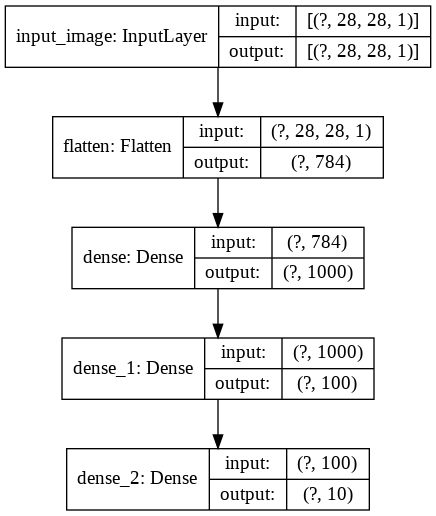

In [4]:
# create and compile model
def create_model(level_0_repeats, level_1_repeats):

    # encoder - input
    model_input = keras.Input(shape=(DATA_ROWS, DATA_COLS, DATA_CHANNELS), name='input_image')
    x           = keras.layers.Flatten()(model_input)
    
    # encoder - level 0
    for n0 in range(level_0_repeats):
        x = keras.layers.Dense(MODEL_LEVEL_0_OUTPUTS, activation='relu')(x)
    
    # encoder - level 1
    for n1 in range(level_1_repeats):
        x = keras.layers.Dense(MODEL_LEVEL_1_OUTPUTS, activation='relu')(x)
    
    # encoder - output
    encoder_output = x

    # decoder
    decoder_output = keras.layers.Dense(DATA_NUM_CLASSES, activation='softmax')(encoder_output)
    
    # forward path
    model = keras.Model(inputs=model_input, outputs=decoder_output, name='mnist_model')

    # loss, backward path (implicit) and weight update
    model.compile(optimizer=tf.keras.optimizers.Adam(TRAINING_LR_MAX), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # return model
    return model

# create and compile model
model = create_model(MODEL_LEVEL_0_REPEATS, MODEL_LEVEL_1_REPEATS)

# model description and figure
model.summary()
keras.utils.plot_model(model, 'mnist_model.png', show_shapes=True)

# debug - model metrics (values returned from model.evaluate)
# print(model.metrics_names) # ['loss', 'accuracy']

# Train and Validate

Epoch 1/9
1875/1875 [==============================] - 11s 6ms/step - loss: 0.9859 - accuracy: 0.7940 - val_loss: 0.4510 - val_accuracy: 0.8999
Epoch 2/9
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1851 - accuracy: 0.9454 - val_loss: 0.1002 - val_accuracy: 0.9694
Epoch 3/9
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1006 - accuracy: 0.9686 - val_loss: 0.0956 - val_accuracy: 0.9719
Epoch 4/9
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0810 - accuracy: 0.9741 - val_loss: 0.0810 - val_accuracy: 0.9748
Epoch 5/9
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0502 - accuracy: 0.9839 - val_loss: 0.0729 - val_accuracy: 0.9784
Epoch 6/9
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0312 - accuracy: 0.9900 - val_loss: 0.0667 - val_accuracy: 0.9811
Epoch 7/9
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0171 - accuracy: 0.9946 - val_loss: 0.0676 - val_accuracy: 0.981

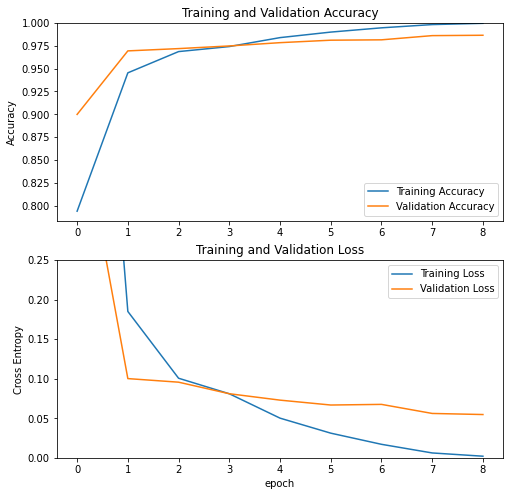

In [5]:
# learning rate schedule
def lr_schedule(epoch):

    # staircase
    # lr = TRAINING_LR_MAX*math.pow(TRAINING_LR_SCALE, math.floor(epoch/TRAINING_LR_EPOCHS))

    # linear warmup followed by cosine decay
    if epoch < TRAINING_LR_INIT_EPOCHS:
        lr = (TRAINING_LR_MAX - TRAINING_LR_INIT)*(float(epoch)/TRAINING_LR_INIT_EPOCHS) + TRAINING_LR_INIT
    else:
        lr = (TRAINING_LR_MAX - TRAINING_LR_FINAL)*max(0.0, math.cos(((float(epoch) - TRAINING_LR_INIT_EPOCHS)/(TRAINING_LR_FINAL_EPOCHS - 1.0))*(math.pi/2.0))) + TRAINING_LR_FINAL

    # debug - learning rate display
    # print(epoch)
    # print(lr)

    return lr

# plot training accuracy and loss curves
def plot_training_curves(history):

    # training and validation data accuracy
    acc     = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # training and validation data loss
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    # plot accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    # plot loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 0.25])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# callbacks (learning rate schedule)
callbacks = [keras.callbacks.LearningRateScheduler(lr_schedule)]

# training
initial_epoch_num = 0
history           = model.fit(x=dataset_train, epochs=TRAINING_NUM_EPOCHS, verbose=1, callbacks=callbacks, validation_data=dataset_test, initial_epoch=initial_epoch_num)

# plot accuracy and loss curves
plot_training_curves(history)

# Test

In [6]:
# test
test_loss, test_accuracy = model.evaluate(x=dataset_test)
print('Test loss:     ', test_loss)
print('Test accuracy: ', test_accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 0.0547 - accuracy: 0.9865
Test loss:      0.054718781262636185
Test accuracy:  0.9865000247955322


# Display

Predicted label: 2 and actual label: 2


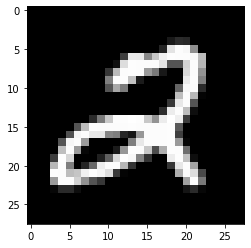

Predicted label: 0 and actual label: 0


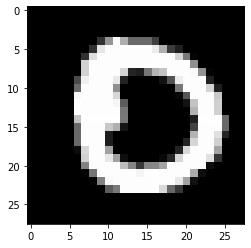

Predicted label: 4 and actual label: 4


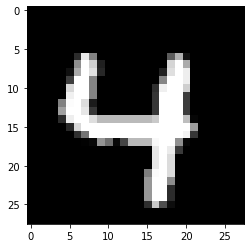

Predicted label: 8 and actual label: 8


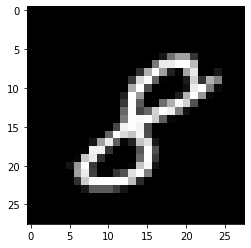

Predicted label: 7 and actual label: 7


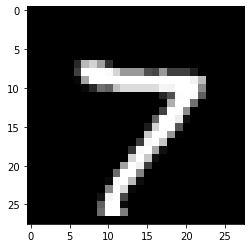

Predicted label: 6 and actual label: 6


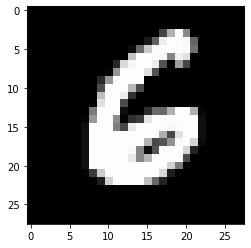

Predicted label: 0 and actual label: 0


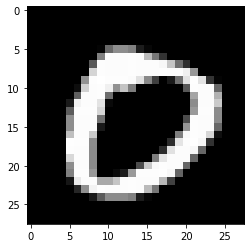

Predicted label: 6 and actual label: 6


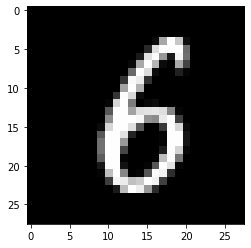

Predicted label: 3 and actual label: 3


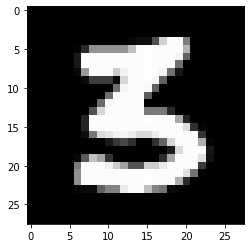

Predicted label: 1 and actual label: 1


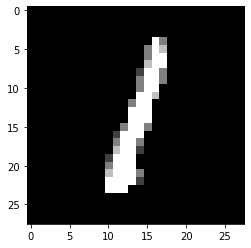

Predicted label: 8 and actual label: 8


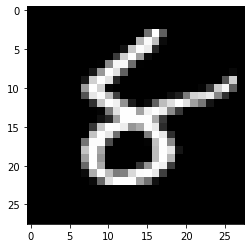

Predicted label: 0 and actual label: 0


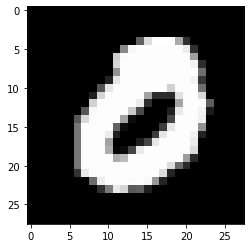

Predicted label: 7 and actual label: 7


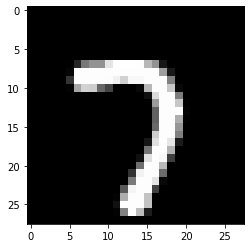

Predicted label: 9 and actual label: 9


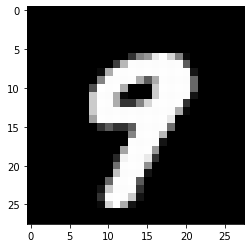

Predicted label: 8 and actual label: 8


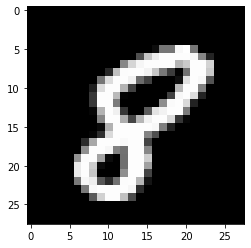

Predicted label: 4 and actual label: 4


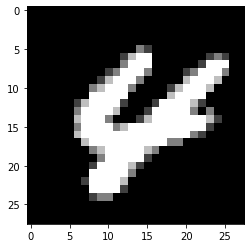

Predicted label: 5 and actual label: 5


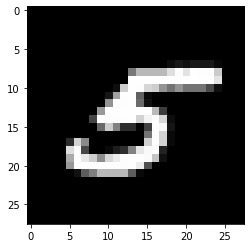

Predicted label: 3 and actual label: 3


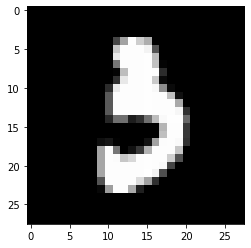

Predicted label: 4 and actual label: 4


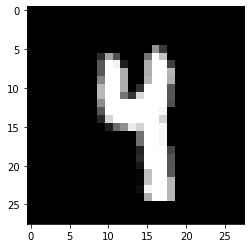

Predicted label: 0 and actual label: 0


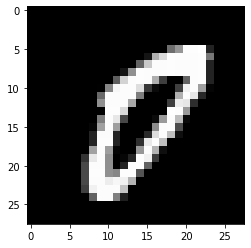

Predicted label: 6 and actual label: 6


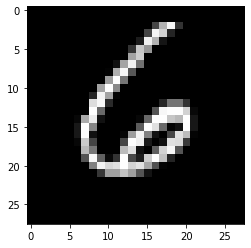

Predicted label: 6 and actual label: 6


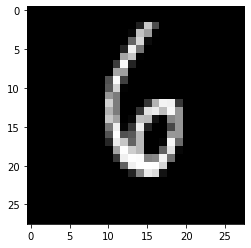

Predicted label: 3 and actual label: 3


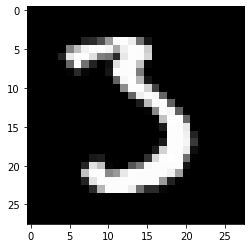

Predicted label: 0 and actual label: 0


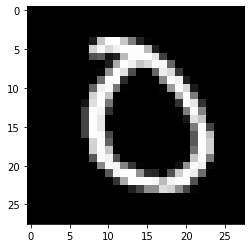

Predicted label: 2 and actual label: 2


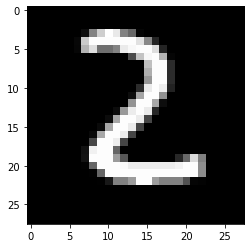

Predicted label: 3 and actual label: 3


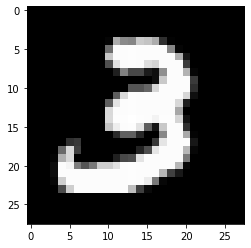

Predicted label: 6 and actual label: 6


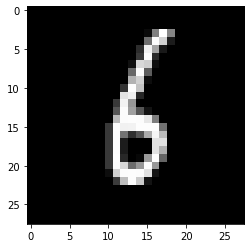

Predicted label: 6 and actual label: 6


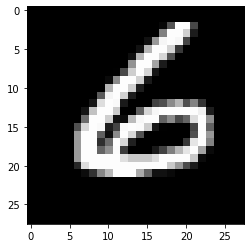

Predicted label: 7 and actual label: 7


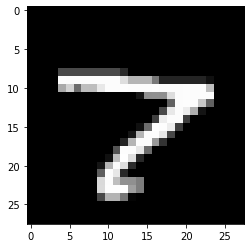

Predicted label: 4 and actual label: 4


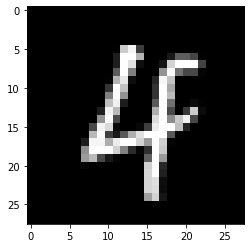

Predicted label: 9 and actual label: 9


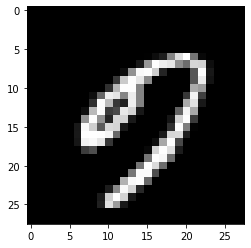

Predicted label: 3 and actual label: 3


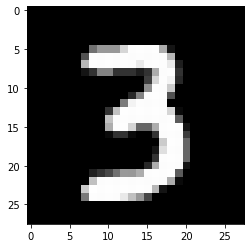

In [7]:
# extract a batch from the testing dataset
# then extract images and labels for this batch
dataset_display                = dataset_test.take(1)
it                             = iter(dataset_display)
display_images, display_labels = next(it)

# predict pmf and labels for this dataset
predict_labels_pmf = model.predict(x=dataset_display)
predict_labels     = np.argmax(predict_labels_pmf, axis=1)

# cycle through the images in the batch
for image_index in range(predict_labels.size):
    
    # display the predicted label, actual label and image
    print('Predicted label: {0:1d} and actual label: {1:1d}'.format(predict_labels[image_index], display_labels[image_index]))
    plt.imshow(np.squeeze(display_images[image_index, :, :]), cmap='gray')
    plt.show()